In [181]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import nltk
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Given:
### [Real or Fake] : Fake Job Description Prediction
### This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.

## Goal:
### Create a classification model that uses text data features and meta-features and predict which job description are fraudulent or real.

## Load and Analyze the data:

In [182]:
df = pd.read_csv("../data/raw/fake_job_postings.csv", index_col=0)
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17880 entries, 1 to 17880
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15184 non-null  object
 7   benefits             10668 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  fraudulen

In [184]:
df.isna().sum()

title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [185]:
df.shape

(17880, 17)

In [186]:
# Count the occurrences of 0 and 1 in the 'fraudulent' column
fraudulent_counts = df['fraudulent'].value_counts()
fraudulent_counts



fraudulent
0    17014
1      866
Name: count, dtype: int64

<Axes: xlabel='fraudulent', ylabel='count'>

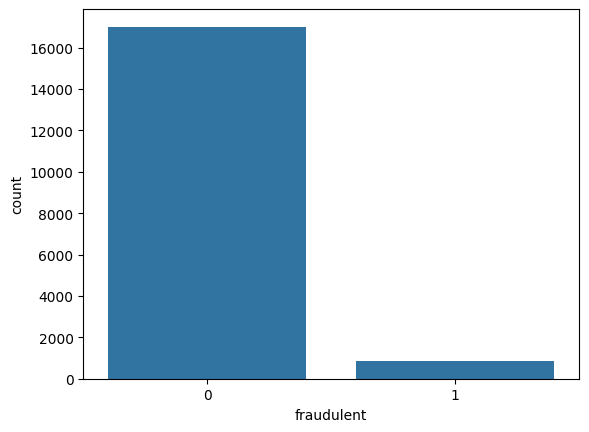

In [187]:
sns.countplot(x = "fraudulent" , data = df)

## Select features:


In [188]:
#get numerical columns:
numerical_colums = df.select_dtypes(include=['number']).columns.tolist()
print(numerical_colums)

['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']


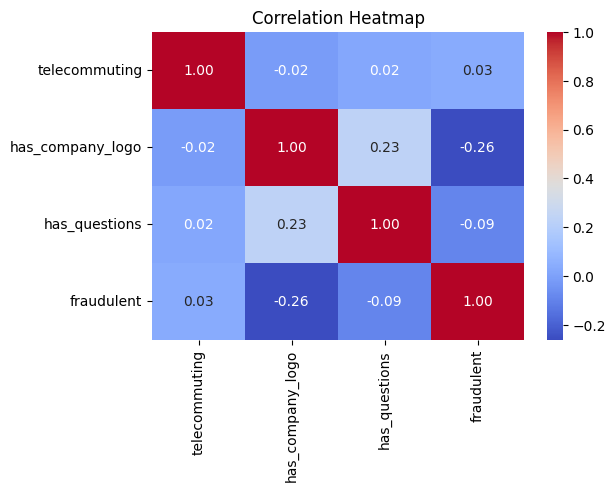

In [189]:
correlation = df[numerical_colums].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm',fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [190]:
#Since the correlation between 'fraudulent' (target) and all the numerical columns is very low, we can drop the columns:
numerical_colums = ['has_questions', 'telecommuting', 'has_company_logo']
df = df.drop(numerical_colums, axis=1)



In [191]:
# Checking the percentage of nan values in each column:
(df.isna().sum() / len(df)) * 100

title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.078300
benefits               40.335570
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64

In [192]:
#Drop the columns with more than 80% of missing values
df = df.dropna(axis=1, thresh=int(len(df) * 0.2))
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17880 entries, 1 to 17880
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   company_profile      14572 non-null  object
 4   description          17879 non-null  object
 5   requirements         15184 non-null  object
 6   benefits             10668 non-null  object
 7   employment_type      14409 non-null  object
 8   required_experience  10830 non-null  object
 9   required_education   9775 non-null   object
 10  industry             12977 non-null  object
 11  function             11425 non-null  object
 12  fraudulent           17880 non-null  int64 
dtypes: int64(1), object(12)
memory usage: 1.9+ MB


In [193]:

print(df.isna().sum())
# Create a LabelEncoder object
le = LabelEncoder()
# Creat empty DataFrame to store encoded data
df_encoded = pd.DataFrame()
# Label encode each column

for col in df.columns:
    
    df_encoded[col] = le.fit_transform(df[col])
    

df_encoded.head()
  
#there are nan values in the columns that are encoded


title                      0
location                 346
department             11547
company_profile         3308
description                1
requirements            2696
benefits                7212
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


,title,location,department,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent
0,6043,2535,758,1526,4506,3829,6204,2,4,13,131,22,0
1,2183,1073,1161,50,7255,10525,5569,1,6,13,75,7,0
2,1763,1867,1337,1389,7470,4560,6204,5,7,13,131,37,0
3,299,1703,1054,975,9590,3166,3333,1,5,1,22,31,0
4,975,1741,1337,1210,5724,6494,2254,1,5,1,51,16,0


In [194]:
# Get unique labels for each columns
for col in df_encoded.columns:
    print(f"{col}: {df_encoded[col].unique()}")



title: [6043 2183 1763 ... 8881  268 7579]
location: [2535 1073 1867 ... 1626  101  766]
department: [ 758 1161 1337 ...   75   82  606]
company_profile: [1526   50 1389 ...  392 1338 1225]
description: [ 4506  7255  7470 ... 10355  4258  7024]
requirements: [ 3829 10525  4560 ...   152  1789   443]
benefits: [6204 5569 3333 ... 5456 2548 1707]
employment_type: [2 1 5 3 0 4]
required_experience: [4 6 7 5 0 2 3 1]
required_education: [13  1  5  4  9  7 10  2  0  6  3  8 11 12]
industry: [131  75  22  51  89  58  39  72  35  61  37  24 119  26  23  88  31  11
   8  41  42  49  59  30  27 118 124  67  53  94  38  66  70  71 107  76
 103  25  79  32  52  85  74   6  95 123  98  69  29  45   0  34  80  63
   4  77 105  78  57 112 117  19  14   7  12 101  21   9  15 108 126   1
 130 111  90 122 129  62  87  68  20  10  99  48  33 127 110   3  46  13
  18 114 113   5  73  43  50 109  83  65  47  92 116  82  54  60 100 120
  17  64  91 121  96  56 128 104  16  81  28 125  36  93  55 102  86  8

In [195]:
df_encoded.corr()['fraudulent']

title                 -0.041619
location               0.092803
department            -0.044887
company_profile        0.123293
description           -0.008302
requirements           0.006058
benefits               0.024851
employment_type        0.057070
required_experience    0.041328
required_education     0.048955
industry               0.037297
function              -0.047461
fraudulent             1.000000
Name: fraudulent, dtype: float64

### NAN values are way to high in the dataset if we drop them all there will be no data to train the model on since the dataset is imbalanced and there is a high chance that that will remove the lower amount of targeted values.

- we could make a filter that keeps the value '1' terget and removes the ones that have '0' in them since there is alot of them
- it still keeps the nan values in those rows and they get label encoded
- using mode, mean or a placeholder to fill nan values is not going to work since these are string objects that have no correlation between each other and are unique values. With 2 exceptions which I don't think would work either.
- this is to check feature importance which will work with only 'employment_type' which is missing 19% of values (and I also think that it has a weak correlation with the target) and also 'required_experience' with 8 labels is missing 39% of its values. Everything else has over 10 labels.

### Conclusion: Encoding for this set is not recommended



## Text Data Cleaning:
- Perform lemmatization text data.

### Method 1

In [196]:
#make a copy of the dataset
df_combined_text = df.copy()


In [197]:
df_combined_text.fillna(' ', inplace=True)


In [198]:
#concatenate all the text columns
df_combined_text['text'] =df_combined_text['title'] + ' ' + df_combined_text['location'] + ' ' + df_combined_text['department'] + ' ' + df_combined_text['company_profile'] + ' ' + df_combined_text['description'] + ' ' + df_combined_text['requirements'] + ' ' + df_combined_text['benefits'] + ' ' + df_combined_text['employment_type'] + ' ' + df_combined_text['required_education'] + ' ' + df_combined_text['industry'] + ' ' + df_combined_text['function'] 


In [199]:
#drop the original text columns
del df_combined_text['title']
del df_combined_text['location']
del df_combined_text['department']
del df_combined_text['company_profile']
del df_combined_text['description']
del df_combined_text['requirements']
del df_combined_text['benefits']
del df_combined_text['employment_type']
del df_combined_text['required_experience']
del df_combined_text['required_education']
del df_combined_text['industry']
del df_combined_text['function']

In [200]:
df_combined_text.head()

,fraudulent,text
job_id,,
1,0,"Marketing Intern US, NY, New York Marketing We..."
2,0,"Customer Service - Cloud Video Production NZ, ..."
3,0,"Commissioning Machinery Assistant (CMA) US, IA..."
4,0,"Account Executive - Washington DC US, DC, Wash..."
5,0,"Bill Review Manager US, FL, Fort Worth SpotS..."


In [201]:
# Download required data if not already downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lzy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lzy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lzy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [202]:

# Create a lemmatizer and load stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


# Define a function to lemmatize a column
def lemmatize_column(column):
    if column.dtype != 'object':
        return column
    else:
        lemmas = []
        for token in column:
            if pd.notnull(token):
                # Remove punctuation
                text = ''.join(char for char in token if char not in string.punctuation)
                # Convert to lowercase
                text = text.lower()
                # Split into tokens
                tokens = text.split()
                # Remove stop words
                filtered_tokens = [token for token in tokens if token not in stop_words]
                # Lemmatize tokens
                lemmas.append(' '.join([lemmatizer.lemmatize(token) for token in filtered_tokens]))
            else:
                lemmas.append(None)
        return pd.Series(lemmas)
    

In [203]:
# Apply the lemmatizer to the 'text' column
df_combined_text['text'] = lemmatize_column(df_combined_text['text'])

In [204]:
# Checking for null values and empty strings
df_combined_text.dropna(subset=['text'], inplace=True)


In [205]:
df_combined_text['text'][1]


'customer service cloud video production nz auckland success 90 second world cloud video production service90 second world cloud video production service enabling brand agency get high quality online video content shot produced anywhere world 90 second make video production fast affordable managed seamlessly cloud purchase publish http90urlfbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd63090 second remove hassle cost risk speed issue working regular video production company managing every aspect video project beautiful online experience growing global network 2000 rated video professional 50 country managed dedicated production success team 5 country 90 second provides 100 success guarantee90 second produced almost 4000 video 30 country 500 global brand including world largest including paypal l’oreal sony barclays office auckland london sydney tokyo singaporehttp90urlfbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd630 http90urle2ad0bde3f09a0913a486abdbb1e6ac

### Method 2

In [206]:

description_df = df.copy()
description_df = description_df[['description','fraudulent']]

# Checking for null values and empty strings

print(f"{description_df.isna().sum()} null values")
print(f"{(description_df == '').sum()} empty strings")
print(description_df.shape)

description    1
fraudulent     0
dtype: int64 null values
description    0
fraudulent     0
dtype: int64 empty strings
(17880, 2)


In [207]:
#removing null values

description_df.dropna(subset=['description'], inplace=True)
print(f"{description_df.isna().sum()} null values")


description    0
fraudulent     0
dtype: int64 null values


## Save the dataset

In [208]:
#save the dataset

#For method 1
df_combined_text.to_csv("../data/processed/df_combined_text.csv")

#For method 2
description_df.to_csv("../data/processed/description_df.csv")